In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In this notebook, we will reproduce the Feature Engineering Pipeline from the notebook 2 (02-Machine-Learning-Pipeline-Feature-Engineering), but we will replace, whenever possible, the manually created functions by open-source classes, and hopefully understand the value they bring forward.

In [2]:
# loading dataset
data = pd.read_csv("train.csv")

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Separate dataset into train and test
It is important to separate our data intro training and testing set.

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

mean
mode
exponents for the yeo-johnson
category frequency
and category to number mappings
from the train set.

Separating the data into train and test involves randomness, therefore, we need to set the seed.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Id", "SalePrice"]), 
    data["SalePrice"], 
    test_size=0.1, 
    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

Feature Engineering
In the following cells, we will engineer the variables of the House Price Dataset so that we tackle:

Missing values
Temporal variables
Non-Gaussian distributed variables
Categorical variables: remove rare labels
Categorical variables: convert strings to numbers
Standardize the values of the variables to the same range
Target
We apply the logarithm

# Target

we apply the logarithm

In [20]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# Categorical Vars 1

Missing values
Categorical variables
We will replace missing values with the string "missing" in those variables with a lot of missing data.

Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values.

This is common practice.

In [21]:
cat_vars = [var for var in data.columns if data[var].dtype == "object"]

In [22]:
len(cat_vars)

43

In [23]:
# MSSubClass is also categorical by definition, despite its numeric values
cat_vars = cat_vars + ['MSSubClass']

In [24]:
X_train[cat_vars] = X_train[cat_vars].astype("object")
X_test[cat_vars] = X_test[cat_vars].astype("object")

In [25]:
# make a list of the categorical variables that contain missing values
cat_vars_with_na = [var for var in cat_vars if X_train[var].isnull().sum() > 0]
        
# print percentage of missing val
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageCond      0.056317
GarageQual      0.056317
GarageFinish    0.056317
GarageType      0.056317
BsmtFinType2    0.025114
BsmtExposure    0.025114
BsmtFinType1    0.024353
BsmtCond        0.024353
BsmtQual        0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

In [26]:
# variables to replace with string
with_string_missing = [var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

In [27]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [28]:
# variables to replace with the most frequent category
with_frequent_category = [var for var in cat_vars_with_na if X_train[var].isnull().mean()<0.1]

In [29]:
with_frequent_category

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

# replace missing values with missing ( opensource method)

In [33]:
#Alternative 1: 
# replace missing values with missing
#X_train[with_string_missing] = np.where(X_train[with_string_missing].isnull(), "missing", X_train[with_string_missing])



# Alternative 2: ****

# set up the class
#a)
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing)

#b)
cat_imputer_missing.fit(X_train)

#c) class learns and stores the parameters
cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'FireplaceQu': 'Missing',
 'PoolQC': 'Missing',
 'Fence': 'Missing',
 'MiscFeature': 'Missing'}

In [34]:
#d) done
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

# replace missing values with most frequent value (opensource method)

In [39]:
#Alternative 1: 
# for var in with_frequent_category:
    
#     mode = X_train[var].mode()[0]
    
#     print(var, mode)
    
#     X_train[var].fillna(mode, inplace=True)
#     X_test[var].fillna(mode, inplace=True)


#Alternative 2: ****

#a)  set up the class
cat_imputer_frequent = CategoricalImputer(
    imputation_method='frequent', variables=with_frequent_category)

#b) 
cat_imputer_frequent.fit(X_train)

#c)
cat_imputer_frequent.imputer_dict_

{'MasVnrType': 'None',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA'}

In [40]:
#d) done
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [43]:
# no missing data
X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

# Numerical Vars 1

In [52]:
num_vars = [var for var in X_train.columns if var not in cat_vars and var != "SalePrice"]

In [53]:
len(num_vars)

35

In [56]:
# make a list with the numerical variables that contain missing values
vars_with_na = [var for var in num_vars if X_train[var].isnull().sum()>0]

In [57]:
vars_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [58]:
X_train[vars_with_na]

,LotFrontage,MasVnrArea,GarageYrBlt
930,73.0,0.0,2007.0
656,72.0,54.0,1959.0
45,61.0,412.0,2005.0
1348,NaN,0.0,1998.0
55,100.0,272.0,1964.0
...,...,...,...
763,82.0,673.0,1999.0
835,60.0,0.0,1996.0
1216,68.0,0.0,1978.0
559,NaN,18.0,2003.0


In [ ]:
# adding missing indicator "_na" columns Nan == 1 else 0

#Alternative 1:
# replace missing values:

# first create a binary column for indicating missing val with 1 and then replace missing val with mean

# for var in vars_with_na:
    
#     # calculate mean, since there is only one mean no need to add [0]
#     mean = X_train[var].mean()
    
#     #creating a new col with _na
#     X_train[var + "_na"] = np.where(X_train[var].isnull(), 1, 0)
#     X_test[var + "_na"] = np.where(X_test[var].isnull(), 1, 0)
    
#     # replacing missing val with mean
#     X_train[var].fillna(mean, inplace = True)
#     X_test[var].fillna(mean, inplace=True)

In [59]:
# Alternative 2: ****

#a)
missing_ind = AddMissingIndicator(variables=vars_with_na)

missing_ind.fit(X_train)

X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

# check the binary missing indicator variables
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


In [60]:
#b) then replace missing data with the mean

# set the imputer
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=vars_with_na)

# learn and store parameters from train set
mean_imputer.fit(X_train)

# the stored parameters
mean_imputer.imputer_dict_

{'LotFrontage': 69.87974098057354,
 'MasVnrArea': 103.7974006116208,
 'GarageYrBlt': 1978.2959677419356}

In [61]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)

In [62]:
# IMPORTANT: note that we could save the all imputers with joblib

#below are what we have used

# __CATEGORICAL
# cat_imputer_missing
# cat_imputer_frequent

# __NUMERICAL
# missing_ind and mean_imputer



# Temporal variables

In [63]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [64]:
# now we drop YrSold
drop_features = DropFeatures(features_to_drop=['YrSold'])

X_train = drop_features.fit_transform(X_train)
X_test = drop_features.transform(X_test)

# Numerical Vars 2

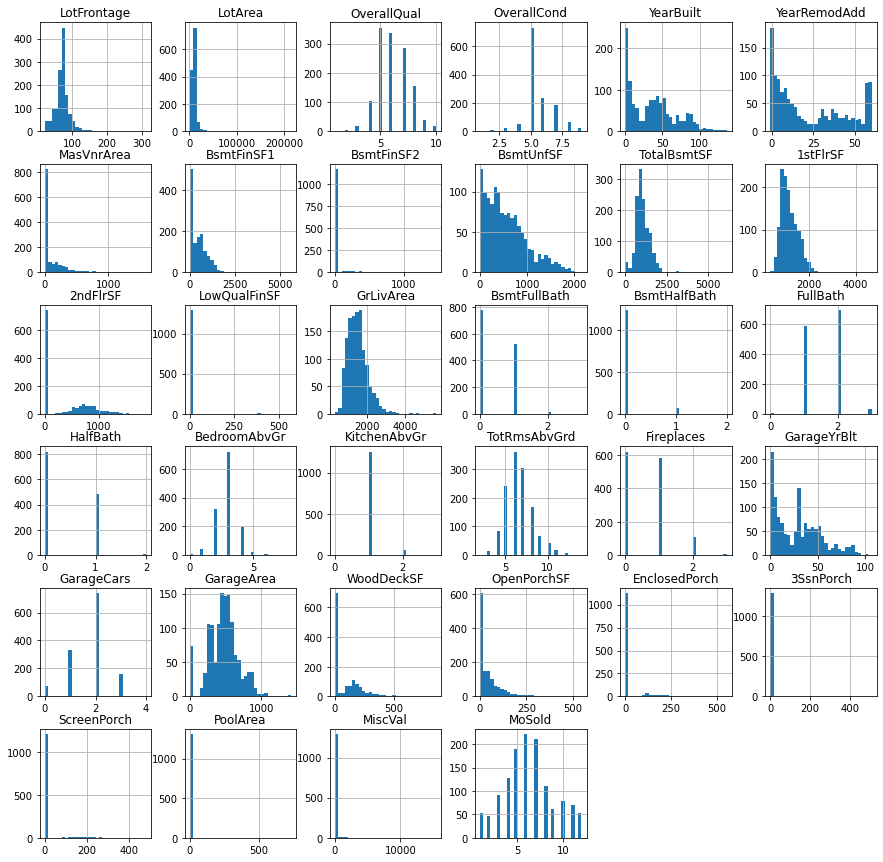

In [74]:
X_train[num_vars].hist(bins=30, figsize=(15,15))
plt.show()

# Logarithmic transformation

In [75]:
#Alternative 1:
# Logarithmic transformation 

# for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
#     X_train[var] =  np.log( X_train[var])
#     X_test[var] =  np.log( X_test[var])
    
    
    
#Alternative 2: ****
log_transformer = LogTransformer(
    variables=["LotFrontage", "1stFlrSF", "GrLivArea"])

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

# Yeo-Johnson transformation

In [76]:
# Alternative 1: 
# Yeo-johnson transformation

# the yeo-johnson transformation learns the best exponent to transform the variable
# it needs to learn it from the train set: 
# X_train['LotArea'], param = stats.yeojohnson(X_train['LotArea'])

# # and then apply the transformation to the test set with the same
# # parameter: see who this time we pass param as argument to the 
# # yeo-johnson
# X_test['LotArea'] = stats.yeojohnson(X_test['LotArea'], lmbda=param)

# print(param)

yeo_transformer = YeoJohnsonTransformer(
    variables=['LotArea'])

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

# the learned parameter
yeo_transformer.lambda_dict_

/Users/gorkemvarol/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/gorkemvarol/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/gorkemvarol/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
/Users/gorkemvarol/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)


{'LotArea': -12.55283001172003}

In [78]:
X_train['LotArea']

930     0.079663
656     0.079663
45      0.079663
1348    0.079663
55      0.079663
          ...   
763     0.079663
835     0.079663
1216    0.079663
559     0.079663
684     0.079663
Name: LotArea, Length: 1314, dtype: float64

# Binarize skewed variables

In [79]:


skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]



# # Alternative 1:
# for var in skewed:
    
#     X_train[var] = np.where(X_train[var] == 0, 0, 1)  
#     X_train[var] = np.where(X_train[var] == 0, 0, 1)

# Alternative 2:  ****
    
binarizer = SklearnTransformerWrapper(
    transformer=Binarizer(threshold=0), variables=skewed
)


X_train = binarizer.fit_transform(X_train)
X_test = binarizer.transform(X_test)

X_train[skewed].head()    
    

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,0,0,0,0,0,0
656,0,0,0,0,0,0
45,0,0,0,0,0,0
1348,0,0,0,0,0,0
55,0,0,0,1,0,0


# Categorical Vars 2

In [80]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [81]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [82]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [83]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [84]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [85]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

# Removing Rare Labels

In [87]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [88]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

# find common labels
rare_encoder.fit(X_train)

# the common labels are stored, we can save the class
# and then use it later :)
rare_encoder.encoder_dict_

{'MSZoning': ['RL', 'RM', 'FV', 'RH'],
 'Street': ['Pave'],
 'Alley': ['Missing', 'Grvl', 'Pave'],
 'LotShape': ['Reg', 'IR1', 'IR2'],
 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
 'Utilities': ['AllPub'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2'],
 'LandSlope': ['Gtl', 'Mod'],
 'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Somerst',
  'NridgHt',
  'Gilbert',
  'Sawyer',
  'NWAmes',
  'BrkSide',
  'SawyerW',
  'Mitchel',
  'Crawfor',
  'Timber',
  'NoRidge',
  'IDOTRR',
  'ClearCr',
  'SWISU',
  'StoneBr',
  'MeadowV',
  'Blmngtn',
  'BrDale'],
 'Condition1': ['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'],
 'Condition2': ['Norm'],
 'BldgType': ['1Fam', 'TwnhsE', 'Duplex', 'Twnhs', '2fmCon'],
 'HouseStyle': ['1Story', '2Story', '1.5Fin', 'SLvl', 'SFoyer'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['VinylSd',
  'HdBoard',
  'Wd Sdng',
  'MetalSd',
  'Plywood',
  'CemntBd',
  'BrkFace',
  'Stucco',
  'WdShing',
  'AsbShng'],


In [89]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

# Encoding of categorical variables

In [ ]:
# Alterntaive 1:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price

# def replace_categories(train, test, y_train, var, target):
    
#     tmp = pd.concat([X_train, y_train], axis=1)
    
#     # order the categories in a variable from that with the lowest
#     # house sale price, to that with the highest
#     ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

#     # create a dictionary of ordered categories to integer values
#     ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
#     print(var, ordinal_label)
#     print()

#     # use the dictionary to replace the categorical strings by integers
#     train[var] = train[var].map(ordinal_label)
#     test[var] = test[var].map(ordinal_label)

In [90]:
# Alternative 2: ****

# set up the encoder
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

# create the mappings
cat_encoder.fit(X_train, y_train)

# mappings are stored and class can be saved
cat_encoder.encoder_dict_

{'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
 'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
 'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
 'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'Edwards': 3,
  'BrkSide': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'SawyerW': 10,
  'Rare': 11,
  'NWAmes': 12,
  'Gilbert': 13,
  'Blmngtn': 14,
  'CollgCr': 15,
  'Crawfor': 16,
  'ClearCr': 17,
  'Somerst': 18,
  'Timber': 19,
  'StoneBr': 20,
  'NridgHt': 21,
  'NoRidge': 22},
 'Condition1': {'Artery': 0,
  'Feedr': 1,
  'Norm': 2,
  'RRAn': 3,
  'Rare': 4,
  'PosN': 5},
 'Condition2': {'Rare': 0, 'Norm': 1},
 'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fa

In [91]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [92]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [93]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

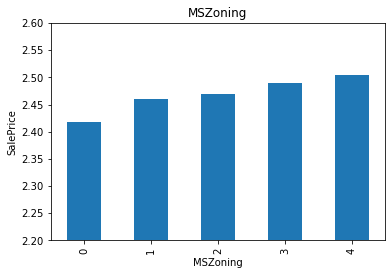

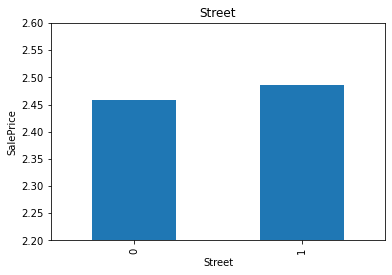

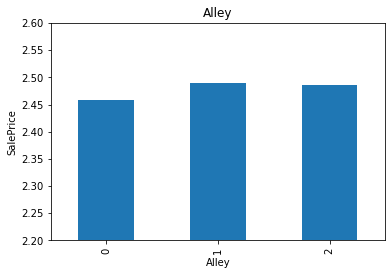

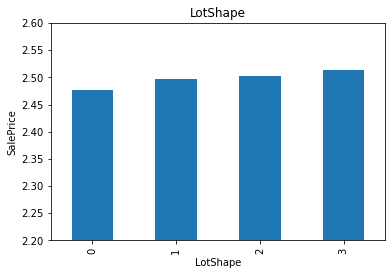

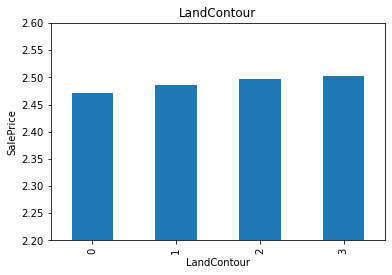

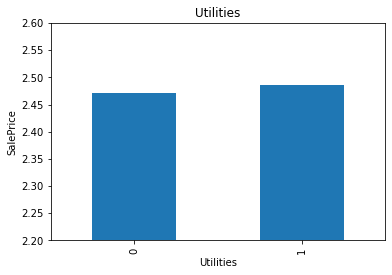

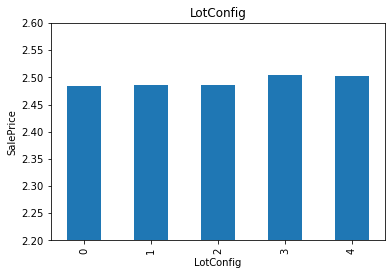

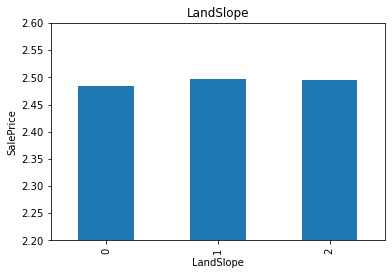

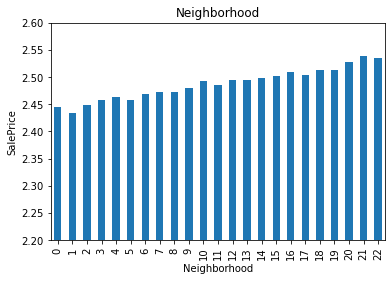

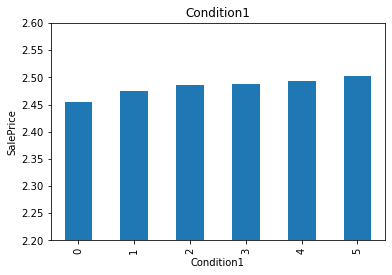

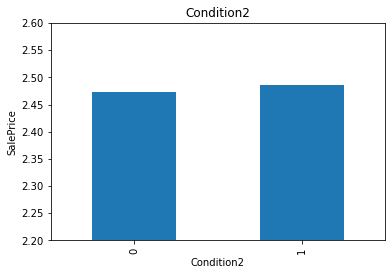

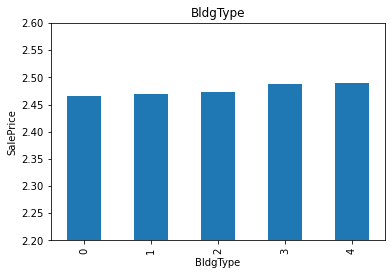

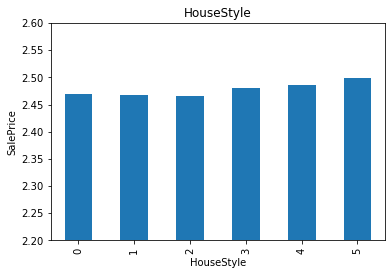

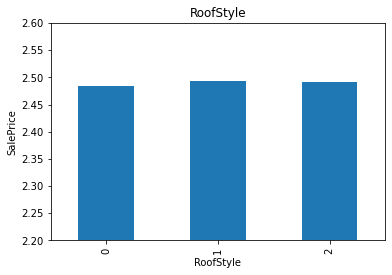

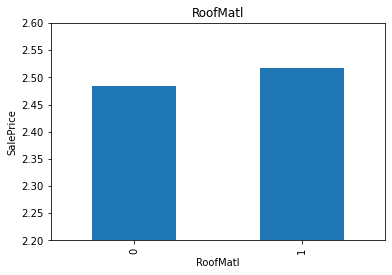

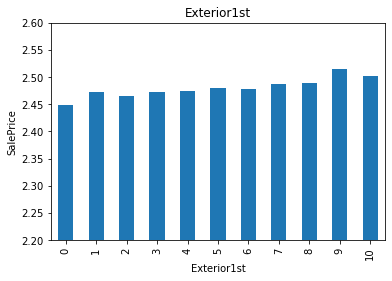

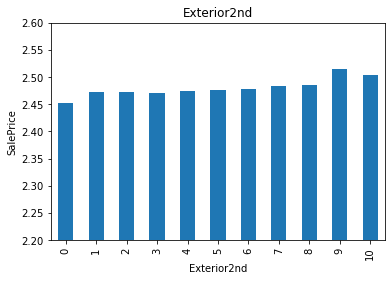

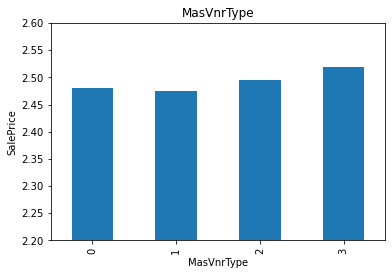

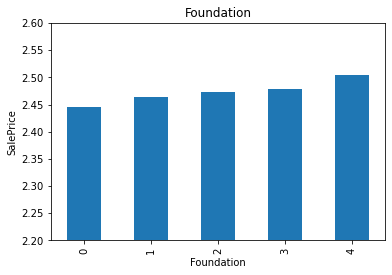

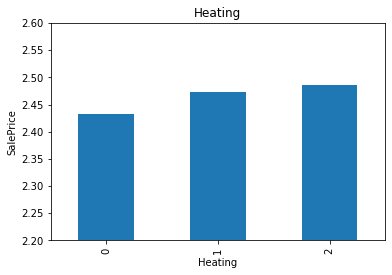

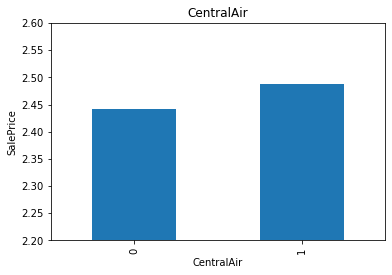

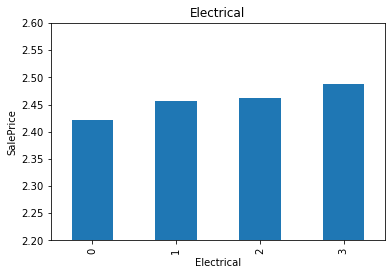

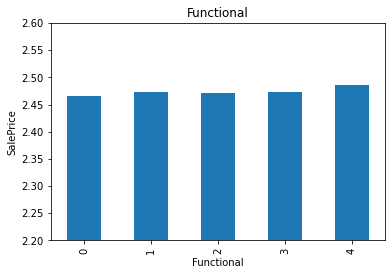

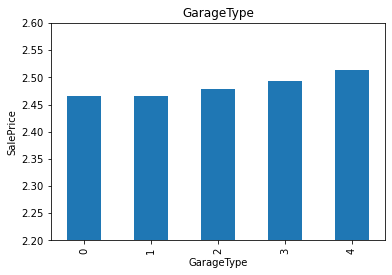

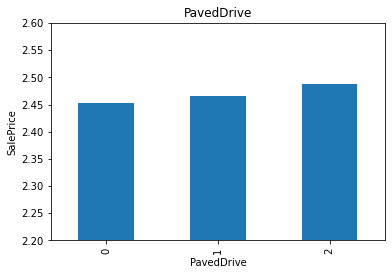

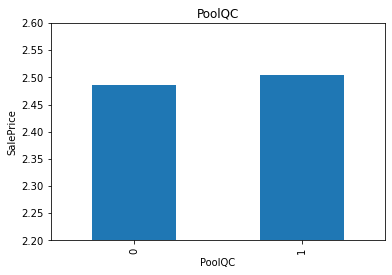

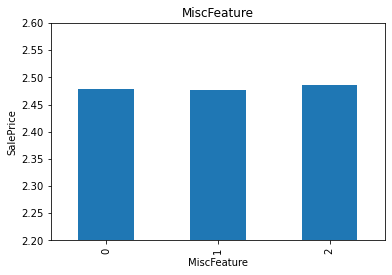

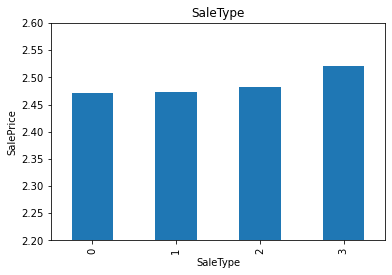

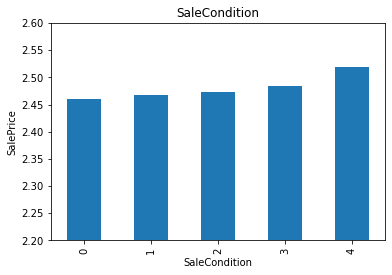

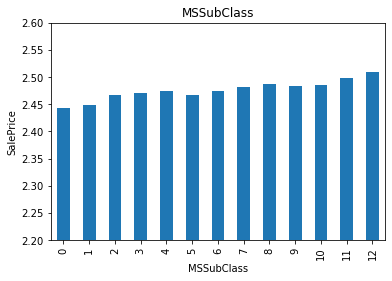

In [94]:
# let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(train, y_train, var):
    
    # function plots median house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

# Feature Scaling

In [95]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [96]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.461171,0.0,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.75,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0
1,0.750000,0.75,0.456066,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,0.5,0.5,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.75,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
2,0.916667,0.75,0.394699,0.0,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,0.5,1.0,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.75,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.090909,0.666667,0.75,0.0,0.0,0.0
3,0.750000,0.75,0.445002,0.0,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.75,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.636364,0.666667,0.75,1.0,0.0,0.0
4,0.750000,0.75,0.577658,0.0,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,0.5,0.5,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.75,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0
